In [1]:
import torch
from torch.autograd import Variable
from torch.distributions import Normal
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss
import pickle
import random

In [2]:
import sys
sys.path.insert(0,'../vp_class/')

In [3]:
from class_tou_v6 import tOU, tou_gradient

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.64 and 0.01 repectively.

m(t) = $\alpha$t + $m_{0}$

1. Simulate prior process, i.e. double-well system whose SDE is given by

$dX_{t} = 4X_{t}(1-X^{2}_{t})dt + \sigma dW_{t}$

In [4]:
with open('../EX03_DW_Model', 'rb') as f:
    prior = pickle.load(f)
    likelihood = pickle.load(f)

In [5]:
def prior_drift (s, x_s):
    return 4 * x_s * (1 - (x_s ** 2))

In [6]:
true_sde_pts, true_sde_trj = prior[0], prior[1]
obs, obs_time = likelihood[0], likelihood[1]
sde_sigma = 0.8 # Variance is higher than the original example
obs_sigma = 0.1

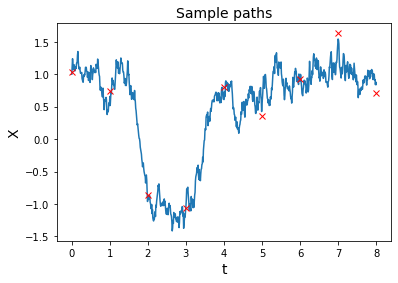

In [7]:
# Plot paths
plt.plot(true_sde_pts,true_sde_trj)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


Variational inference: KL

2. Implement Variational inference based on $\textbf{time-inhomogeneous}$ OU process with SDE:

$$dX_{t} = [-\frac{a}{at+b}X_{t} + (ct+d)] dt + \sigma^{2} dW_{t}$$

$$\mathbb{E}_{P^{Z}}[\log\exp{\frac{dP^{X}}{dP^{Z}}(Z)] = \frac{1}{2}\mathbb{E}_{P^{Z}}[\int_{t_{0}}}^{t_{1}}|\frac{4Z_{t}(1-Z^{2}_{t}) + \frac{a}{at+b}Z_{t} - (ct+d)}{\sigma}|^{2}dt]$$


In [8]:
class ELBO:
    """
        ELBO with
            variational process (q): time-inhomogeneous OU process
            prior process (p): double-well system
            
        This class computes: - KL(q|p) + NLL(y|z)  where z \sim q
    """
    def __init__(self, ou):
        self.ou = ou
        self.a = ou.a
        self.b = ou.b
        self.c = ou.c
        self.d = ou.d
        
        self.sigma = ou.sigma
        

    def KL(self, prior_drift):
        """
            This function requires the function corresponding to prior drift function
        """
        # Save parameter specification from ou class
        a, b, c, d, sigma = self.a, self.b, self.c, self.d, self.sigma

        
        def approx_drift(pts, trj, a, b, c, d):
            return -1 * ((a * trj / (a*pts + b)) - c*pts - d)
            
        t = self.ou.pts - self.ou.pts[:, 0].reshape(-1, 1)
        
        dt = t[:, -1] - t[:, 0]

        # Evaluate the drift function of the approximating processes
        g_of_x = approx_drift(t, self.ou.trj, a, b, c, d)
        
        # Evaluate the drift function of the model (prior process)
        f_of_x = prior_drift(t, self.ou.trj)
        
        # Compute the term inside the KL divergence
        
        F_of_X = abs(((f_of_x - g_of_x) / sigma) ** 2)
        
        return 0.5 * torch.sum(F_of_X, axis=1).reshape(-1, 1) / F_of_X.shape[1] * dt.reshape(-1, 1)
            
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


**Variational inference: a piece-wise approximation**

In [9]:
import tqdm as tq

In [10]:
def score_estimate(s0, sK, current_pars, sigma, obs, obs_sigma, init_dist, M):
    """
        Returns stochastic estimates of the gradient of the ELBO with respect to parameters including
            alpha, r, beta
        
        M: # of Monte Carlo samples
        
    """
    assert obs.shape[0] == 1, "observation must be 1-d torch.array"
    
    # Number of time points drawn between s0 and sK
    K = 200
    
    # Reshape every parameter into (M,1) torch.array
    SIGMA = sigma.repeat(M, 1)
    OBS = obs.repeat(M, 1)
    # Simulate sample path
    # Note that z0 = m0
    
    pars = {key:val.repeat(M, 1) for key,val in current_pars.items()}
    
    vi = tOU(t0=s0, t1=sK, parameters = pars, sde_sigma=SIGMA, init_dist = init_dist, timegrid = 'False', dN=K)

    # Compute the ELBO 
    elbo = ELBO(vi)
    score_func = tou_gradient(vi.pts, vi.trj, pars, SIGMA, init_dist)
    f_of_x = -elbo.log_prob(OBS, obs_sigma) + elbo.KL(prior_drift)
    
    return {key: torch.nanmean(f_of_x * score_func[key]) for key in pars.keys()}, torch.nanmean(f_of_x)

Sanity check

Examine the distribution of score function estimates of the gradient of each parameter.

In [ ]:
dist = Normal(loc=0, scale=1.)
t0 = torch.tensor(1.)
t1 = torch.tensor(2.)
sigma = torch.tensor([1.]).reshape(-1, 1)

In [ ]:
parameters = {'a': torch.tensor([0.05]).reshape(-1, 1), \
             'b': torch.tensor([0.8]).reshape(-1, 1), \
             'c': torch.tensor([0.05]).reshape(-1, 1), \
             'd': torch.tensor([1.0]).reshape(-1, 1)}

In [ ]:
init_pts = torch.tensor([1.0]).reshape(-1, 1)

In [ ]:
tou = tOU(t0, t1, parameters, sigma, init_dist=init_pts)

In [ ]:
ELBO(tou).KL(prior_drift)

In [ ]:
estimates = {key:[] for key in parameters.keys()}

for i in range(500):
    grads = score_estimate(t0, t1, parameters, sigma, obs[0], obs_sigma, init_pts, 2000)
    for key in grads.keys():
        estimates[key].append(grads[key].item())

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
par_names = list(estimates.keys())

for j, ax in enumerate(axs.ravel()):
    ax.hist(estimates[par_names[j]], bins=30)
    ax.axvline(np.mean(estimates[par_names[j]]), linestyle='dashed', color='black')
    ax.set_title(par_names[j])
    ax.set_xlabel("Gradient estimate")
    ax.set_ylabel("Frequency")

In [11]:
def AdaGrad( current_pars, current_grad, past_grad, learning_rate = 0.01, smooth_term = 1e-8):
    """
        Perform one-step gradient descent based on AdaGrad with Gradient Clipping
    """
    assert type(current_pars) == type(current_grad) == type(past_grad) == dict, "Current_grad must be a dict"
    
    
    new_pars = {}
    for key in current_pars.keys():
        new_pars[key] = current_pars[key] - learning_rate / np.sqrt(past_grad[key] + smooth_term) * current_grad[key]

    return new_pars
    
    

In [12]:
def AdamStep(g_t, m_t, v_t, beta_1, beta_2, t):
    """
        compute bias corrected moments
    """
#     print(g_t, m_t, v_t, beta_1, beta_2, t)
    m_t_next = beta_1 * m_t + (1 - beta_1) * g_t
    v_t_next = beta_2 * v_t + (1 - beta_2) * g_t ** 2
    
    m_t_corrected = m_t_next / (1 - (beta_1 ** t))
    v_t_corrected = v_t_next / (1 - (beta_2 ** t))
    
#     print(m_t_corrected, v_t_corrected)
    return m_t_corrected, v_t_corrected

def AdamGrad(current_pars, current_grad, prev_moments,  beta_1, beta_2, learning_rate = 0.01, smooth_term = 1e-8):
    assert type(current_pars) == type(current_grad) == type(prev_moments) == dict, "Current_grad must be a dict"
    """
        Perform one-step Adam gradient descent
    """
    new_pars = {}
    for key in current_pars.keys():
        m_t, v_t = AdamStep(current_grad[key], prev_moments[key][0], prev_moments[key][1], beta_1, beta_2, prev_moments['t'])
        new_pars[key] = current_pars[key] - learning_rate / np.sqrt(v_t + smooth_term) * m_t
        
        # Save moments for next iteration    
        prev_moments[key][0] = m_t
        prev_moments[key][1] = v_t
    
    prev_moments['t'] += 1
    
    return new_pars
    
    
    

In [13]:
def Grad_Descent( current_pars, current_grad, learning_rate = 0.01):
    """
        Perform vanila gradient descent step
        returns dictionary such that dict["name_of_parameter"] = value after one gradient step
    """
    assert type(current_pars) == type(current_grad) == dict, "Current_grad must be a dict"
    
    
    new_pars = {}
    for key in current_pars.keys():
        new_pars[key] = current_pars[key] - learning_rate * current_grad[key]

    return new_pars
    

In [14]:
def E_of_X ( init_pts, pts, parameters ):
    """
        Return mean of the process (which has analytical expression)
    """
    pts = pts - pts[0]
    a = parameters['a']
    b = parameters['b']
    c = parameters['c']
    d = parameters['d']
    
    return b * (init_pts + 1/b * (a*c*pts ** 3 / 3 + (a*d + b*c)/2 * pts ** 2 + d*b*pts)) /(a*pts + b)
    

In [15]:
def V_of_X (pts, parameters, sde_sigma):
    """
        Return standard deviation of the process (from its analytical expression)
    """
    pts = pts - pts[0]
    a = parameters['a']
    b = parameters['b']
    c = parameters['c']
    d = parameters['d']
    
    return torch.sqrt(sde_sigma ** 2 * (a**2 * pts ** 3 / 3 + a*b*pts**2 + b**2 * pts) / ((a*pts + b) ** 2))

In [16]:
def get_PostMoment(t0, tT, parameters, sde_sigma, init_pts, vN):
    """
        Returns approximate posterior's mean and standard deviation
    """
    # Get time-grid between s0 and sK
    
    t = torch.linspace(0, (tT-t0).item(), vN+2)[1:]
    mean = E_of_X(init_pts, t, parameters)
    std = V_of_X(t, parameters, sde_sigma)
    
    return t, mean, std

**To be added: 1. parameter update history, 2. elbo, KL, and loglikelihood estimate, 3. randomizing initial state**

In [39]:
def Optimize(sde_sigma, obs, obs_time, obs_sigma, M, IT, vN, learning_rate, FIX_PAR, init_state = "Random", Optimizer="Adam", beta_1 = 0.9, beta_2 = 0.999, smooth_term = 1e-8, FIX=True):
    """
        vN: # of time points between in each obs interval on which mean of the approximate posterior process will be evaluated
    """
    assert type(sde_sigma) == torch.Tensor, "SDE sigma must be a torch.Tensor"
    assert type(obs) == torch.Tensor, "obs must be a torch.Tensor"

    N_of_Pars = 4
    
    T = obs.shape[0]
    
    v_N = T * (vN+1) - vN
    
    VP_PTS = np.zeros(v_N)
    VP_MEAN = np.zeros(v_N)
    VP_STD = np.zeros(v_N)
    
    # Intialize the state at the first observation
    init_mean = obs[0]
    VP_MEAN[0] = init_mean
    
    past_grad = {'a':[], 'b':[], 'c':[], 'd':[]}
    past_pars = {key:np.zeros((T-1, IT)) for key in past_grad.keys()}
    
    for t in tq.tqdm(range(1, T)):
        s0 = obs_time[t-1]
        sK = obs_time[t]
        
        if init_state == 'Random':
            if t == 1:
                init_dist = init_mean
            else:
                init_dist = Normal(loc=init_mean, scale= init_std)
        else:
            init_dist = init_mean
            
        # Initialize a set of parameters
        current_pars = {key:torch.randn(1) for key in past_grad.keys()}

        if Optimizer == "Adam":
            prev_moments = {key:[0, 0] for key in current_pars.keys()}
            prev_moments['t'] = 1
            
#    past_grad = {key:torch.tensor([0.01]) for key in current_pars.keys()}
        
        for i in range(IT):
            if (i % (IT/2) == 0):
                for key in current_pars.keys():
                    print(str(i) +"/ " + key + ": "+ str(current_pars[key].item()) )
                    
            # Take gradient descent algorithm based on AdaGrad
            
            # Obtain stochastic estimate of the gradients based on score function estimator
            current_grad, elbo_estimate = score_estimate(s0, sK, current_pars, sde_sigma, obs[t], obs_sigma, init_dist, M)
            print(str(i) +"/ " + str(elbo_estimate.item()))
            
            if elbo_estimate.item() < 20:
                break
            # Take one gradient step based on the AdaGrad
            if Optimizer == "Adam":
                current_pars = AdamGrad(current_pars, current_grad, prev_moments, beta_1, beta_2, learning_rate, smooth_term)
                
            else:
                current_pars = Grad_Descent(current_pars, current_grad, learning_rate)
            
            if FIX == True:
                for key in FIX_PAR.keys():
                    current_pars[key] = FIX_PAR[key]
            
            for key in current_grad.keys():
                past_grad[key].append(current_grad[key].item()) 
                past_pars[key][t-1, i] = current_pars[key].item()
            
        
        # Obtain moments of approximating processes (note that their forms are tractable)
        vp_pts, vp_mean, vp_std = get_PostMoment(s0, sK, current_pars, sde_sigma, init_mean, vN)
        
        VP_PTS[(vN+1)*(t-1)+1:(vN+1)*t+1] = obs_time[t-1] + vp_pts
        VP_MEAN[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_mean
        VP_STD[(vN+1)*(t-1)+1:(vN+1)*t+1] = vp_std
        
        init_mean = vp_mean[-1]
        init_std = vp_std[-1]
        
        print("observation: " + str(obs[t].item()) + " variational mean: " + str(init_mean.item()))
    return VP_PTS, VP_MEAN, VP_STD, past_pars, past_grad

Examine the convergence of parameters / model fit across different initializations/number_of_iterations

In [40]:
# FIX_PAR = {'a':torch.tensor([1.])}

In [42]:
output = []
for it in tq.tqdm([50]):
    vp__pts, vp__mean, vp__std, vp__pars, vp__grads = Optimize(torch.tensor([sde_sigma]),\
                                                      obs, obs_time, obs_sigma, \
                                                      init_state="Random", M=1500, \
                                                      FIX_PAR = FIX_PAR,
                                                               FIX=False, \
                                                      IT=it, vN=150, learning_rate=0.05, \
                                                      Optimizer="Adam", beta_1 = 0.2, beta_2 = 0.01)
    output.append([vp__pts, vp__mean, vp__std, vp__pars, vp__grads])

  0%|                                                     | 0/8 [00:00<?, ?it/s]

0/ a: 0.7456879019737244
0/ b: -0.07177884131669998
0/ c: -0.8577670454978943
0/ d: 0.32830387353897095
0/ 1.2969968850651253e+28
1/ 1.620351821548583e+20
2/ 56.55443718107194
3/ 66.31273603911102
4/ 110.99652441410517
5/ 312.5524371902562
6/ 3699.9810041380715
7/ 232386.19566490583
8/ 18439115.138400506
9/ 1326209336.4111543
10/ 90425189794.80777
11/ 6036457964949.701
12/ 395717760427661.56
13/ 2.5375997527504496e+16
14/ 1.205282037931508e+18
15/ 1.2270930974883843e+18
16/ 1.2325461120693304e+18
17/ 1.2316147125624527e+18
18/ 1.2365007276461642e+18
19/ 1.2391157900722563e+18
20/ 1.2319832838367086e+18
21/ 1.236074285785313e+18
22/ 1.242470859531014e+18
23/ 1.315554404748947e+18
24/ 1.7115599901727255e+18
25/ a: 813401.5625
25/ b: 1722932.625
25/ c: -838.5073852539062
25/ d: -815.3842163085938
25/ 2.1731277127587446e+18
26/ 2.5272195890346527e+18
27/ 2.5475911592866545e+18
28/ 2.5416170178844027e+18
29/ 2.564449913844213e+18
30/ 2.560470025984151e+18
31/ 2.561505231742879e+18
32/ 2.547


 12%|█████▋                                       | 1/8 [00:03<00:26,  3.80s/it]

47/ 2.546796020485404e+18
48/ 2.553689054861278e+18
49/ 2.557580672999825e+18
observation: 0.7418740051633642 variational mean: -1078.9717084540132
0/ a: -1.7633776664733887
0/ b: 0.11293957382440567
0/ c: -0.02031382918357849
0/ d: 0.5800036191940308
0/ 2.3686224360347216e+40
1/ 1.211660806624237e+40
2/ 1.735522261272918e+37
3/ 4.5026743994124444e+36
4/ 9.105302723639629e+30
5/ 2.048264725193185e+17
6/ 3.47739746783149e+17
7/ 5.097098931541488e+17
8/ 6.58723674229917e+17
9/ 7.588947946514875e+17
10/ 8.319423627741805e+17
11/ 8.614127755297135e+17
12/ 8.760183242174833e+17
13/ 8.808577995993832e+17
14/ 8.725428661250275e+17
15/ 8.423895785077683e+17
16/ 2.0536873197198915e+18
17/ 1.4788072739264368e+20
18/ 1.2763820225307045e+22
19/ 9.407849497661905e+23
20/ 5.254546997263512e+24
21/ 5.432659747983304e+24
22/ 5.487352970328098e+24
23/ 5.43381128040453e+24
24/ 5.508236212638451e+24
25/ a: -670171.125
25/ b: -138737.03125
25/ c: 30286.099609375
25/ d: 3852.818359375
25/ 5.485949871039768

  0%|                                                     | 0/1 [00:06<?, ?it/s]

33/ 5.555868944584408e+24


KeyboardInterrupt: 

In [ ]:
it_names = ['30']
par_names = ['a',  'c']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    P, T, IT = len(par_names), obs_time.shape[0], 30

    for t in range(T-1):
        fig, ax = plt.subplots(nrows=1, ncols=P, figsize=(20, 5))
        for j, ax in enumerate(ax.ravel()):
            ax.plot(vp__pars[par_names[j]][t, :])
            ax.set_title(par_names[j] + " at time interval: %d" % t)
            ax.set_xlabel("Iterations")
        title = "Adam_" + "time_" + str(t) + "_iteration_" + name
#         plt.savefig("figures/" + title)
        plt.show()

In [ ]:
it_names = ['10', '30', '50']
for item, name in zip(output, it_names):
    vp__pts, vp__mean, vp__std, vp__pars = item[0], item[1], item[2], item[3]
    
    plt.figure(figsize=(10,6))
    plt.plot(vp__pts.T, vp__mean.T, color='black')
    plt.fill_between(vp__pts, vp__mean + vp__std, vp__mean - vp__std, alpha=0.3, color='grey')
    plt.plot(true_sde_pts, true_sde_trj, alpha=0.2)
    plt.plot(obs_time, obs, 'rx')
    title = "approximating processes / iteration: " + name
    plt.title(title)
    file_name = "Adam_" + "approx_process_" + "iteration_" + name
#     plt.savefig("figures/" + file_name)
    plt.show()

In [ ]:
it_names = ['10', '30', '50']
for item, name in zip(output, it_names):
    vp_grads = item[4]
    plt.figure(figsize=(10,5))

    for key in vp_grads.keys():
        plt.plot(vp_grads[key], label=key, alpha=0.8)
        plt.axhline(np.mean(vp_grads[key]), linestyle='dashed', label=str(np.mean(vp_grads[key]).round(2)))
        plt.legend()
        
    plt.xlabel("Iterations")
    plt.ylabel("Gradient")
    file_name = "Adam_" + "gradient_update_history" + "iteration_" + name
    plt.title(file_name)
    plt.savefig("figures/" + file_name)
    plt.show()